In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

import math

import numpy as np

from pmd_beamphysics import single_particle

from scipy.constants import physical_constants

from gpt import GPT

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6
c = physical_constants['speed of light in vacuum'][0]

DISTGEN_INPUT_FILE = os.path.join(root, 'templates/sectormagnet/distgen.in.yaml')

In [2]:
from gpt.bstatic import Rectmagnet

In [3]:
RM = Rectmagnet('kicker', 0.01, 0.2, 0.001)

In [4]:
RM.place()

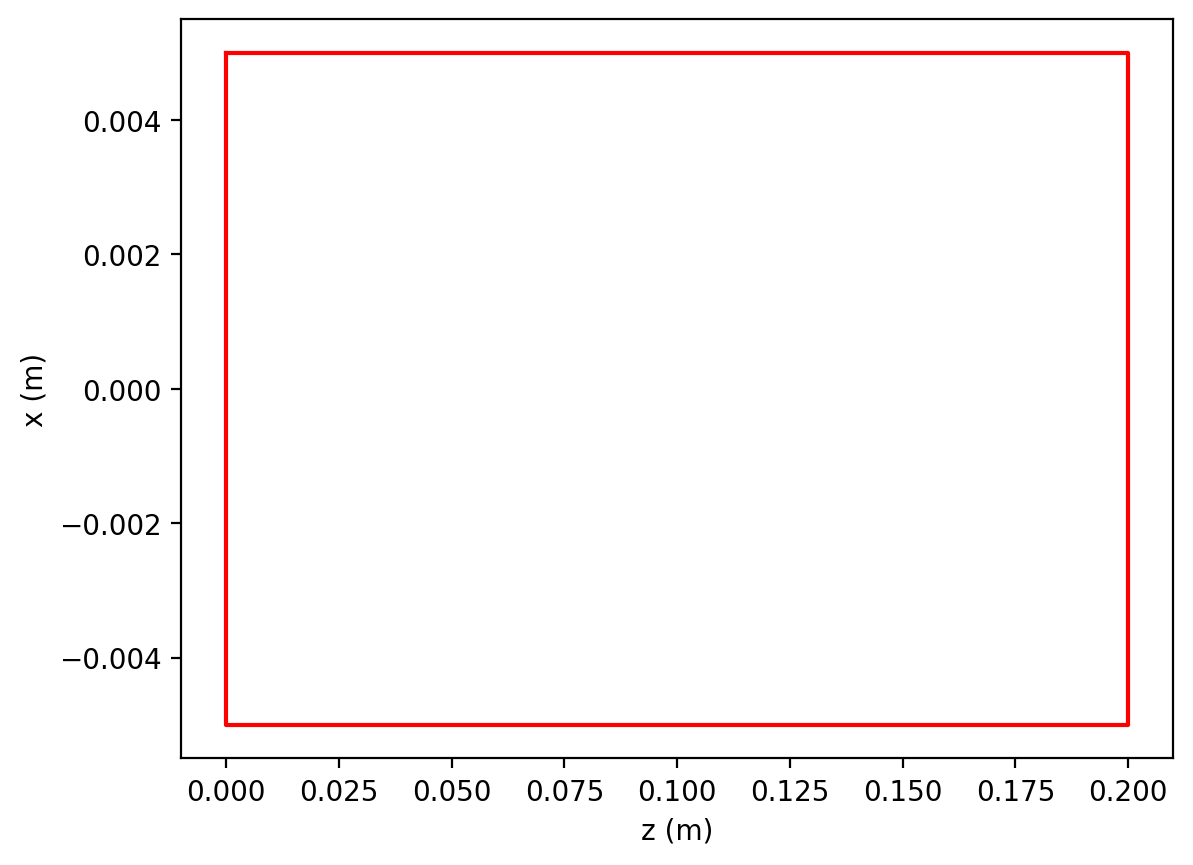

In [5]:
RM.plot_floor()

In [6]:
RM.gpt_lines()

['\n#***********************************************',
 '#             Rectmagnet: kicker           ',
 '#***********************************************',
 'kicker_a = 0.01;',
 'kicker_b = 0.2;',
 'kicker_Bfield = 0.001;',
 'kicker_fringe_dl = 0;',
 'kicker_fringe_b1 = 0;',
 'kicker_fringe_b2 = 0;',
 '\nrectmagnet("wcs", "GxyzXYZ", 0, 0, 0.1, 0, 0, 0, kicker_a, kicker_b, kicker_Bfield,kicker_fringe_dl, kicker_fringe_b1, kicker_fringe_b2);']

In [7]:
from gpt.lattice import Lattice

In [8]:
lat = Lattice('werd')

b = 0.2

kick = 1e-3
E = 1e6
p = np.sqrt(E**2 - MC2**2)

Bfield = p * kick / b / c

gap = 0.01

ds = 0.4

lat.add(Rectmagnet('kicker', 0.05, b, Bfield, gap=gap), ds = ds, element_origin='beg')

$\Delta\theta_x  = \frac{eB\cdot L}{p} $, $B = \frac{p\Delta\theta_x }{e L}$

In [9]:
lat.write_gpt_lines(output_file='gpt.temp.in');

In [10]:
lat['kicker'].gpt_lines()

['\n#***********************************************',
 '#             Rectmagnet: kicker           ',
 '#***********************************************',
 'kicker_a = 0.05;',
 'kicker_b = 0.2;',
 'kicker_Bfield = 1.4336273528626521e-05;',
 'kicker_fringe_dl = 0;',
 'kicker_fringe_b1 = 200.0;',
 'kicker_fringe_b2 = 0;',
 '\nrectmagnet("wcs", "GxyzXYZ", 0, 0, 0.5, 0, 0, 0, kicker_a, kicker_b, kicker_Bfield,kicker_fringe_dl, kicker_fringe_b1, kicker_fringe_b2);']

In [11]:
P1 = single_particle(pz=p)

In [12]:
G = GPT('gpt.temp.in', initial_particles=P1, load_fields=True
       )
G.set_variable('Ntout', 200)

True

In [13]:
G.run()

In [14]:
print(G)




GPT object:
   Original input file: gpt.temp.in
   Template location: /Users/colwyngulliford/GitHub/lume-gpt/examples/elements
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpjsg8c9c6
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.05612492561340332 (sec)


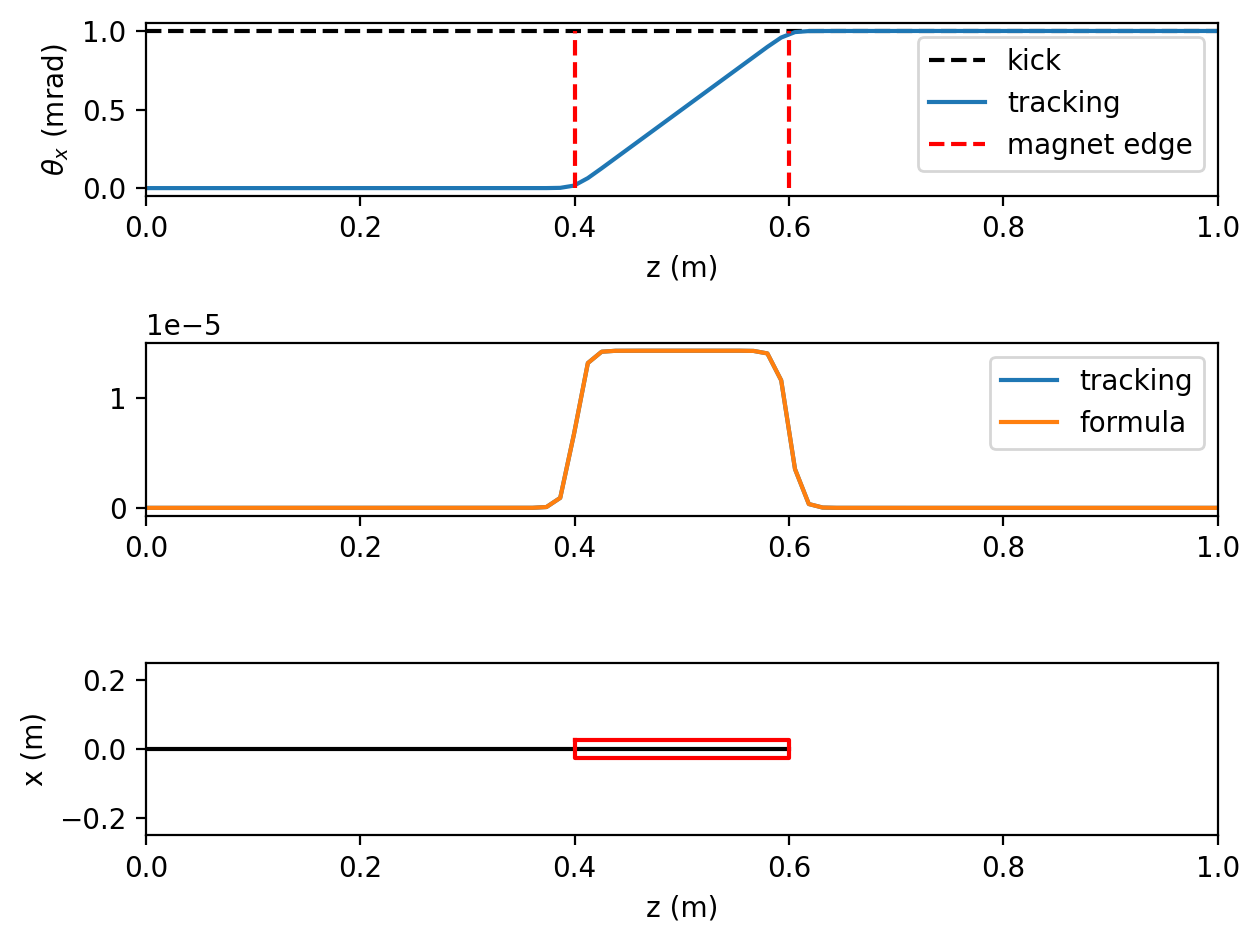

In [15]:
fig, axs = plt.subplots(3, 1)

axs[0].plot([0, 1], [1, 1], '--k')
axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('mean_xp')*1e3);
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\theta_x$ (mrad)')
axs[0].set_xlim([0, 1])

axs[0].plot(ds + np.array([0, 0]), [0, 1], '--r')
axs[0].plot(ds + np.array([b, b]), [0, 1], '--r')

axs[0].legend(['kick', 'tracking', 'magnet edge'])

axs[1].plot(G.tout_stat('mean_z'), G.tout_stat('mean_By'))
axs[1].plot(G.tout_stat('mean_z'), lat['kicker'].b_field(G.tout_stat('mean_z')))
axs[1].legend(['tracking', 'formula'])
axs[1].set_xlim([0, 1])

lat.plot_floor(ax=axs[2],axis=None)
axs[2].set_xlim([0, 1])
axs[2].set_ylim([-0.25, +0.25])

plt.tight_layout()

In [16]:
l2 = Lattice('l2')
l2.parse('gpt.temp.in')

In [17]:
#print(l2)

<Axes: xlabel='z (m)', ylabel='x (m)'>

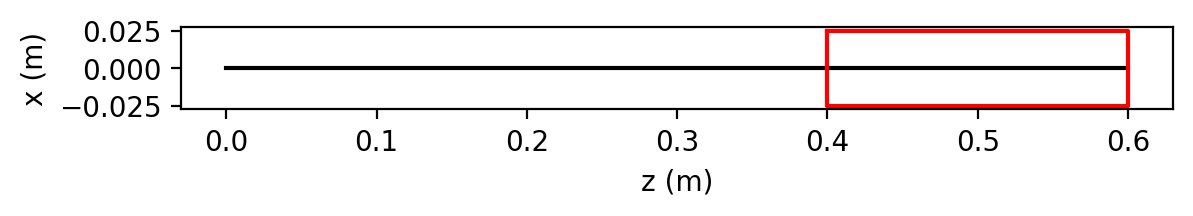

In [18]:
l2.plot_floor()


#os.remove('gpt.temp.in')

In [19]:
G2 = GPT('gpt.temp.in', initial_particles=P1, load_fields=True)
G2.set_variable('Ntout', 500)
G2.run()

In [20]:
print(G2.lattice)

Lattice: lattice
s-start: 0 m.
s-stop: 0.6000000000000001

Name: beg
Type: lattice starting element
s-entrance: 0 m.
s-exit: 0 m.
Length: 0
Width: 0 m.

Name: ele_2
Type: Rectmagnet
s-entrance: 0.4 m.
s-exit: 0.6000000000000001 m.
Length: 0.2
Width: 0.05 m.


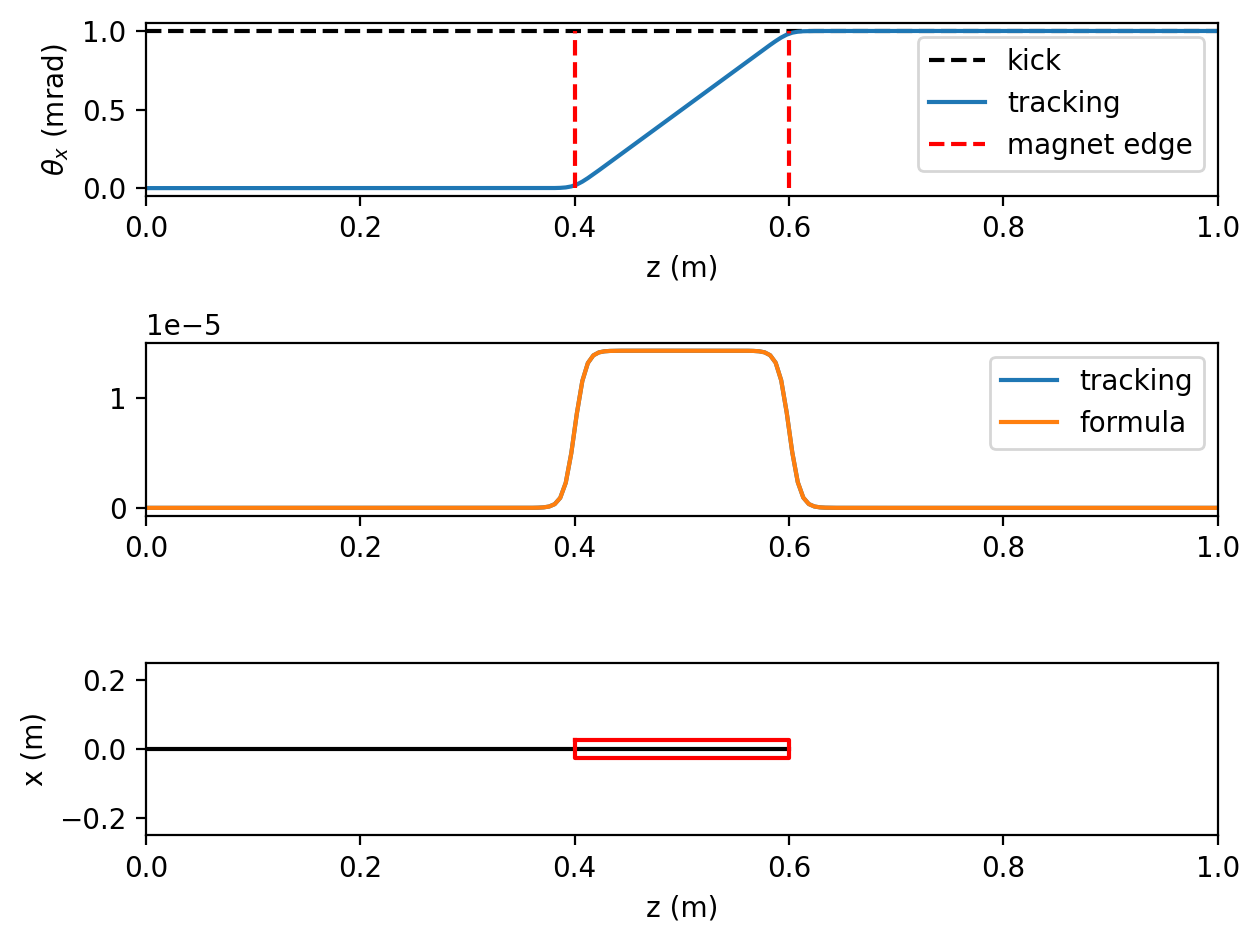

In [21]:
fig, axs = plt.subplots(3, 1)

axs[0].plot([0, 1], [1, 1], '--k')
axs[0].plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_xp')*1e3);
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\theta_x$ (mrad)')
axs[0].set_xlim([0, 1])

axs[0].plot(ds + np.array([0, 0]), [0, 1], '--r')
axs[0].plot(ds + np.array([b, b]), [0, 1], '--r')

axs[0].legend(['kick', 'tracking', 'magnet edge'])

axs[1].plot(G2.tout_stat('mean_z'), G2.tout_stat('mean_By'))
axs[1].plot(G2.tout_stat('mean_z'), G2.lattice['ele_2'].b_field(G2.tout_stat('mean_z')))
axs[1].legend(['tracking', 'formula'])
axs[1].set_xlim([0, 1])

lat.plot_floor(ax=axs[2],axis=None)
axs[2].set_xlim([0, 1])
axs[2].set_ylim([-0.25, +0.25])

plt.tight_layout()

In [22]:
G2.lattice['ele_2'].a, G2.lattice['ele_2'].b

(0.05, 0.2)

In [23]:
os.remove('gpt.temp.in')